# Install pyrecdp from github

In [ ]:
!pip install 'git+https://github.com/intel/e2eAIOK.git#egg=pyrecdp&subdirectory=RecDP'

# Install jdk for pyspark running

In [ ]:
!DEBIAN_FRONTEND=noninteractive apt-get install -y openjdk-8-jre

# Prepare test data

In [21]:
%mkdir -p /content/test_data
%cd /content/test_data
!wget https://raw.githubusercontent.com/intel/e2eAIOK/main/RecDP/tests/data/llm_data/tiny_c4_sample_for_pii.jsonl

/content/test_data
--2023-10-18 13:35:21--  https://raw.githubusercontent.com/intel/e2eAIOK/main/RecDP/tests/data/llm_data/tiny_c4_sample_for_pii.jsonl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12586 (12K) [text/plain]
Saving to: ‘tiny_c4_sample_for_pii.jsonl’

tiny_c4_sample_for_ 100%[===================>]  12.29K  --.-KB/s    in 0s      

2023-10-18 13:35:22 (108 MB/s) - ‘tiny_c4_sample_for_pii.jsonl’ saved [12586/12586]



# Import toxicity score function

In [2]:
from pyrecdp.primitives.llmutils import toxicity_score_spark, toxicity_score
from pyrecdp.core import SparkDataProcessor

JAVA_HOME is not set, use default value of /usr/lib/jvm/java-8-openjdk-amd64/


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


# Specify variables

In [1]:
data_file = '/content/test_data/tiny_c4_sample.jsonl'
save_path = '/content/test_data/output/toxicity_score'

# Load data

In [3]:
rdp = SparkDataProcessor()
spark = rdp.spark
spark_df = spark.read.json(data_file)
spark_df.show()

Will assign 1 cores and 10386 M memory for spark
per core memory size is 10.143 GB and shuffle_disk maximum capacity is 8589934592.000 GB
+--------------------+--------------------+
|                meta|                text|
+--------------------+--------------------+
|{"timestamp":"201...|lorazepam nombre ...|
|{"timestamp":"201...|It is possible to...|
|{"timestamp":"201...|Canon PIXMA TS952...|
|{"timestamp":"201...|For those who pla...|
|{"timestamp":"201...|After tipping 25 ...|
|{"timestamp":"201...|When cute redhead...|
|{"timestamp":"201...|Description: Deco...|
|{"timestamp":"201...|Download BustedBo...|
|{"timestamp":"201...|Judah Ben-Hur liv...|
|{"timestamp":"201...|Beneath you can s...|
|{"timestamp":"201...|It’s Day 11, and ...|
|{"timestamp":"201...|KATALEIYA . LaraE...|
|{"timestamp":"201...|Adhesive furnitur...|
|{"timestamp":"201...|HD Wetting accept...|
|{"timestamp":"201...|Iryna Sysoenko, P...|
|{"timestamp":"201...|Hi. My name is Ha...|
|{"timestamp":"201...|This

# Process the 'text' column and generate toxicity score which will determine whether the row kept or not(spark dataframe interface)

In [4]:
toxicity_score_spark_df = toxicity_score_spark(spark_df)
toxicity_score_spark_df.show()

+--------------------+--------------------+--------------------+
|                meta|                text|       text_toxicity|
+--------------------+--------------------+--------------------+
|{"timestamp":"201...|lorazepam nombre ...|7.045677630230784E-4|
|{"timestamp":"201...|It is possible to...|0.001997147919610...|
|{"timestamp":"201...|Canon PIXMA TS952...|5.388619028963149E-4|
|{"timestamp":"201...|For those who pla...|3.720709937624633...|
|{"timestamp":"201...|After tipping 25 ...|3.255245683249086E-4|
|{"timestamp":"201...|When cute redhead...| 0.02352582849562168|
|{"timestamp":"201...|Description: Deco...| 0.25577104091644287|
|{"timestamp":"201...|Download BustedBo...|2.149254432879388...|
|{"timestamp":"201...|Judah Ben-Hur liv...|0.006481378804892...|
|{"timestamp":"201...|Beneath you can s...|1.922253140946850...|
|{"timestamp":"201...|It’s Day 11, and ...|0.011020174250006676|
|{"timestamp":"201...|KATALEIYA . LaraE...| 0.17913435399532318|
|{"timestamp":"201...|Adh

# Display text data with a possibility of toxicity exceeding 0.2

In [5]:
toxicity_score_spark_df.filter("text_toxicity > 0.2").show()

+-----------+--------------------+--------------------+-------------------+
|__SECRETS__|                meta|                text|      text_toxicity|
+-----------+--------------------+--------------------+-------------------+
|         []|{"timestamp":"201...|SCRAPPY is a supe...|0.40010908246040344|
|         []|{"timestamp":"201...|This dark haired ...|0.25201350450515747|
+-----------+--------------------+--------------------+-------------------+



# Use perspectiveAPI to predict the toxicity of text

In [5]:
!pip install perspective
from perspective import PerspectiveAPI

def prepare_func_text_toxicity_perspective(api_key):
    p = PerspectiveAPI(api_key)
    def generate_toxicity_label(content):
        result = p.score(content)
        return float(result["TOXICITY"])

    return generate_toxicity_label

import pyspark.sql.functions as F
api_key="#####################"
func = F.udf(prepare_func_text_toxicity_perspective(api_key))
toxicity_score_persepectiveAPI_spark_df = toxicity_score_spark_df.withColumn("text_toxicity_perspectiveAPI", func(F.col("text")))


In [6]:
toxicity_score_persepectiveAPI_spark_df.show()

+--------------------+--------------------+--------------------+----------------------------+
|                meta|                text|       text_toxicity|text_toxicity_perspectiveAPI|
+--------------------+--------------------+--------------------+----------------------------+
|{"timestamp":"201...|lorazepam nombre ...|7.045677630230784E-4|                 0.035220183|
|{"timestamp":"201...|It is possible to...|0.001997147919610...|                 0.069754265|
|{"timestamp":"201...|Canon PIXMA TS952...|5.388619028963149E-4|                 0.008419261|
|{"timestamp":"201...|For those who pla...|3.720709937624633...|                 0.112540044|
|{"timestamp":"201...|After tipping 25 ...|3.255245683249086E-4|                 0.013257195|
|{"timestamp":"201...|When cute redhead...| 0.02352582849562168|                  0.36095104|
|{"timestamp":"201...|Description: Deco...| 0.25577104091644287|                   0.3389984|
|{"timestamp":"201...|Download BustedBo...|2.149254432879388

# Display text data with a possibility of toxicity exceeding 0.1 with perspectiveAPI

In [11]:
toxicity_score_persepectiveAPI_spark_df.filter("text_toxicity > 0.1").show()

+--------------------+--------------------+-------------------+----------------------------+
|                meta|                text|      text_toxicity|text_toxicity_perspectiveAPI|
+--------------------+--------------------+-------------------+----------------------------+
|{"timestamp":"201...|Description: Deco...|0.25577104091644287|                   0.3389984|
|{"timestamp":"201...|KATALEIYA . LaraE...|0.17913435399532318|                  0.24603334|
|{"timestamp":"201...|Today, there is a...| 0.4169255197048187|                  0.37073207|
|{"timestamp":"201...|Starring Yasmine ...|0.21636812388896942|                  0.54823303|
|{"timestamp":"201...|At age fifteen, s...| 0.2836323082447052|                0.0137598375|
|{"timestamp":"201...|What is this hot ...|0.18693310022354126|                  0.45396814|
|{"timestamp":"201...|Upload a picture ...|0.25675785541534424|                  0.16851899|
|{"timestamp":"201...|Advice, Animals, ...| 0.5879350304603577|       

# Use profanity_check to predict the profanity of text

In [24]:
from profanity_check import predict_prob
def prepare_func_profanity_score(content):
  scores = predict_prob([content])
  return float(scores[0])

import pyspark.sql.functions as F
func = F.udf(prepare_func_profanity_score)
profanity_score_spark_df = toxicity_score_spark_df.withColumn("text_profanity_score", func(F.col("text")))
profanity_score_spark_df.show()

+--------------------+--------------------+--------------------+--------------------+
|                meta|                text|       text_toxicity|text_profanity_score|
+--------------------+--------------------+--------------------+--------------------+
|{"timestamp":"201...|lorazepam nombre ...|7.045677630230784E-4|0.040039424167676106|
|{"timestamp":"201...|It is possible to...|0.001997147919610...|0.028989691808218948|
|{"timestamp":"201...|Canon PIXMA TS952...|5.388619028963149E-4|   0.043861183352844|
|{"timestamp":"201...|For those who pla...|3.720709937624633...|0.004377341418335424|
|{"timestamp":"201...|After tipping 25 ...|3.255245683249086E-4|0.009099317732054453|
|{"timestamp":"201...|When cute redhead...| 0.02352582849562168| 0.04230116186167876|
|{"timestamp":"201...|Description: Deco...| 0.25577104091644287| 0.09813155457491825|
|{"timestamp":"201...|Download BustedBo...|2.149254432879388...|0.014691897752754538|
|{"timestamp":"201...|Judah Ben-Hur liv...|0.006481378

In [25]:
profanity_score_spark_df.filter("text_profanity_score > 0.1").show()

+--------------------+--------------------+--------------------+--------------------+
|                meta|                text|       text_toxicity|text_profanity_score|
+--------------------+--------------------+--------------------+--------------------+
|{"timestamp":"201...|It’s Day 11, and ...|0.011020174250006676|  0.1075886803904289|
|{"timestamp":"201...|wing back chair c...|0.004366231616586447|  0.2310903976563441|
|{"timestamp":"201...|A flirty flared t...|0.011921738274395466|    0.16461638282759|
|{"timestamp":"201...|House for a trip ...|0.006529421545565128| 0.19788234991696743|
|{"timestamp":"201...|Today, there is a...|  0.4169255197048187| 0.13755844069518922|
|{"timestamp":"201...|Starring Yasmine ...| 0.21636812388896942|  0.3046393001622488|
|{"timestamp":"201...|What is this hot ...| 0.18693310022354126| 0.15193193949897144|
|{"timestamp":"201...|Upload a picture ...| 0.25675785541534424| 0.16366510186922595|
|{"timestamp":"201...|Naughty office 3....|6.181608769

# Compare the toxicity score between detoxify and perspectiveAPI.

In [18]:
toxicity_score_pd = toxicity_score_persepectiveAPI_spark_df.limit(20).toPandas()

<Axes: title={'center': 'Quality score of datasets'}>

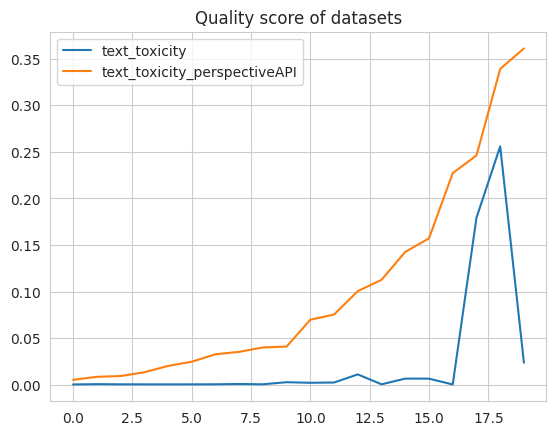

In [16]:
import pandas as pd
toxicity_score_pd["text_toxicity"] = pd.to_numeric(toxicity_score_pd["text_toxicity"])
toxicity_score_pd["text_toxicity_perspectiveAPI"] = pd.to_numeric(toxicity_score_pd["text_toxicity_perspectiveAPI"])
toxicity_score_pd.sort_values(by=["text_toxicity_perspectiveAPI"]).reset_index().plot(y=["text_toxicity", "text_toxicity_perspectiveAPI"], kind="line", title="Quality score of datasets")